# **Importacion paquetes**
---

In [6]:
import pandas as pd
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# **Carga de datos**
---

In [7]:
data=pd.read_csv('../../limpieza/coments/Dataset_Review_cleaned_v1.csv')
data.head()

,name,imagen,user_id,apart_id,ubicacion,first_name,gender,rating,sentimiento,pregunta,...,num_adj,text_clean,tokens,prob_ruido,prob_limp,prob_ubi,prob_wf,prob_park,prob_bañ,num_toks
0,Barbara Diaz,https://a0.muscache.com/im/pictures/user/e97d0...,-5345305016665044310,https://www.airbnb.es/rooms/46527977?adults=1&...,6,Barbara,0.0,3.0,0.0,1.0,...,10.0,absolutamente bien lugar camas duras lejos cen...,"['absolutamente', 'bien', 'lugar', 'camas', 'd...",0.0,1.0,0.0,0.0,0.0,0.0,62.0
1,Txema,https://a0.muscache.com/im/pictures/user/0c5a3...,7554217637905518485,https://www.airbnb.es/rooms/46527977?adults=1&...,8,Txema,1.0,4.0,0.0,1.0,...,1.0,buenas gestión atención volveré usar casa,"['buenas', 'gestión', 'atención', 'volveré', '...",0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,Aloe,https://a0.muscache.com/im/pictures/user/4df2c...,2753252670262692822,https://www.airbnb.es/rooms/46527977?adults=1&...,9,Aloe,2.0,1.0,0.0,1.0,...,7.0,empezar mundos corre cobren euros tener wifi p...,"['empezar', 'mundos', 'corre', 'cobren', 'euro...",0.0,0.0,0.0,1.0,0.0,0.0,35.0
3,Nichola,https://a0.muscache.com/im/pictures/user/b8437...,5933799744255950932,https://www.airbnb.es/rooms/46527977?adults=1&...,6,Nichola,0.0,5.0,0.0,1.0,...,8.0,situado mejor zona benidorm vistas hermosa pla...,"['situado', 'mejor', 'zona', 'benidorm', 'vist...",0.0,0.0,0.0,0.0,0.0,0.0,28.0
4,Elena,https://a0.muscache.com/im/pictures/user/b8f5e...,3658483447196535546,https://www.airbnb.es/rooms/46527977?adults=1&...,6,Elena,0.0,5.0,0.0,1.0,...,2.0,pasamos estancia agradable gustado,"['pasamos', 'estancia', 'agradable', 'gustado']",0.0,0.0,0.0,0.0,0.0,0.0,4.0


# **Correlaciones**
---

<Axes: >

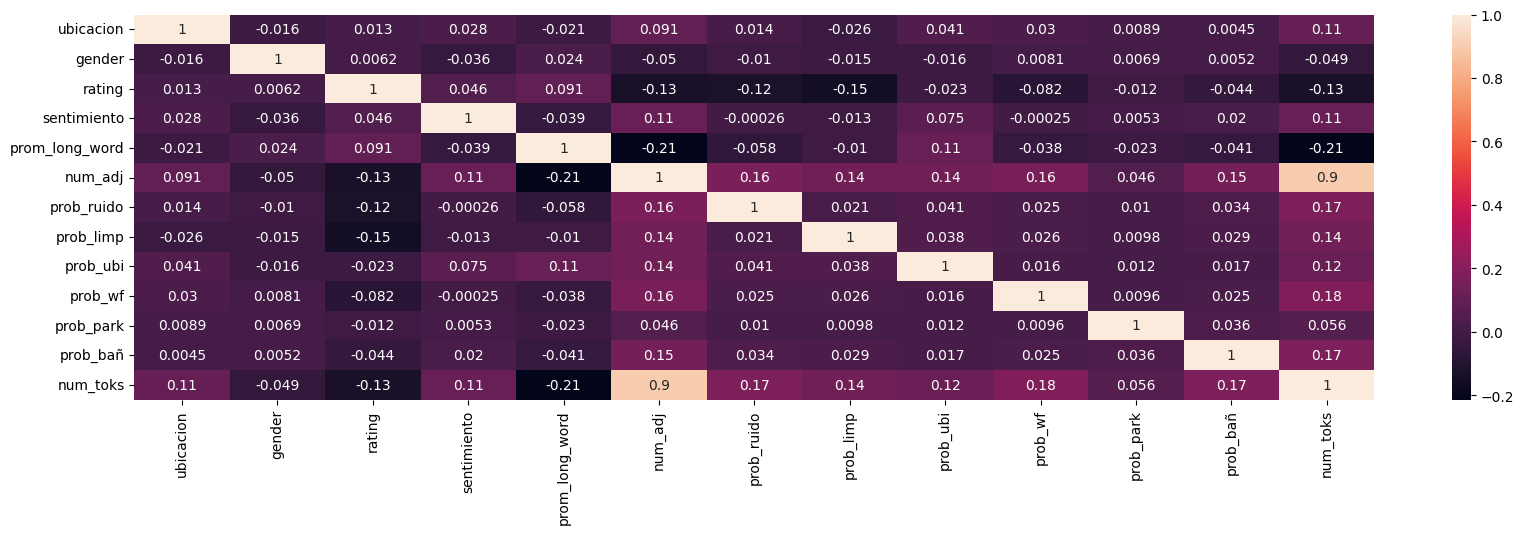

In [15]:
num_cols=data[[col for col in data.columns if col not in ['user_id','pregunta']]].select_dtypes(exclude='object').columns
plt.figure(figsize=(20,5))
sns.heatmap(data[num_cols].corr(),annot=True)


In [16]:
data[num_cols].var()

ubicacion           6.994279
gender              0.440351
rating              0.250198
sentimiento         0.053081
prom_long_word      0.671230
num_adj            21.433803
prob_ruido          0.030133
prob_limp           0.036412
prob_ubi            0.182408
prob_wf             0.014564
prob_park           0.006175
prob_bañ            0.012835
num_toks          309.200082
dtype: float64

# **VIF**
---

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_cols=data[[col for col in data.columns if col not in ['user_id']]].select_dtypes(exclude='object').columns
dfvif = data[num_cols]
vif_estan = [[dfvif.columns[i], variance_inflation_factor(dfvif.to_numpy(), i)] for i in range(dfvif.shape[1])]
df_vif_estan=pd.DataFrame(vif_estan)
df_vif_estan=df_vif_estan.rename(columns = {0:'Variable',1:'VIF'})
df_vif_estan.sort_values(by='VIF',ascending=False)

,Variable,VIF
4,pregunta,145.495942
13,num_toks,5.434251
6,num_adj,5.313762
5,prom_long_word,1.077581
2,rating,1.062574
9,prob_ubi,1.046894
8,prob_limp,1.044491
7,prob_ruido,1.043561
10,prob_wf,1.038808
12,prob_bañ,1.032960


Pregunta la podemos eliminar, no tiene varianza.

# **Catboost Feature importance**
---

In [11]:
catreg=CatBoostRegressor(silent=True)
datos=data.drop(['user_id','apart_id','tokens','text_clean','imagen','name','first_name'],axis=1)
X=datos.drop('rating',axis=1)
y=data['rating']

catreg.fit(X,y)

In [12]:
pd.DataFrame(zip(catreg.feature_importances_,catreg.feature_names_),columns=['Importance','Var']).sort_values(by='Importance',ascending=False)

,Importance,Var
4,22.403156,prom_long_word
12,20.494147,num_toks
5,11.975284,num_adj
2,10.527194,sentimiento
0,9.631165,ubicacion
7,8.101818,prob_limp
1,4.908570,gender
6,4.823871,prob_ruido
9,3.834933,prob_wf
8,2.359094,prob_ubi


En conclusion eliminamos las variables pregunta,name y first name.

In [18]:
data_var_select=data.drop(['pregunta','name','first_name'],axis=1)
data_var_select.to_csv('DatasetAirbnb_Review_Varselect_v1.csv',index=False)